In [137]:
import pandas as pd
import numpy as np
from loaders import wind_data

wind_GEF = wind_data(path_name='data/wind_data_all_zone.csv', test_size=50, random_state=0)
wind_df = pd.read_csv('data/wind_data_all_zone.csv')
print(wind_GEF[5].index[0])
wind_df['TIMESTAMP'] =  pd.to_datetime(wind_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
wind_df['new_date'] = [d.date() for d in wind_df['TIMESTAMP']]
wind_df

#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
2012-07-15 01:00:00


,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,ZONE_1,ZONE_2,ZONE_3,ZONE_4,ZONE_5,ZONE_6,ZONE_7,ZONE_8,ZONE_9,ZONE_10,new_date
0,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,0,0,0,0,0,0,0,0,0,2012-01-01
1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,1,0,0,0,0,0,0,0,0,0,2012-01-01
2,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,1,0,0,0,0,0,0,0,0,0,2012-01-01
3,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,1,0,0,0,0,0,0,0,0,0,2012-01-01
4,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,1,0,0,0,0,0,0,0,0,0,2012-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175435,2013-12-31 20:00:00,0.792143,1.032363,-6.281558,2.041033,-11.220655,0,0,0,0,0,0,0,0,0,1,2013-12-31
175436,2013-12-31 21:00:00,0.792143,1.702361,-6.202448,2.846245,-10.486079,0,0,0,0,0,0,0,0,0,1,2013-12-31
175437,2013-12-31 22:00:00,0.792143,5.086629,-1.261378,7.382256,-3.097656,0,0,0,0,0,0,0,0,0,1,2013-12-31
175438,2013-12-31 23:00:00,0.792143,4.183751,-1.580172,5.789054,-2.116548,0,0,0,0,0,0,0,0,0,1,2013-12-31


In [138]:
dates = []
for d in wind_GEF[5].index:
    dates.append(d.date())
dates = pd.Series(dates)
dates.unique()
train = wind_df[~wind_df['new_date'].isin(dates.unique())].copy()
test = wind_df[wind_df['new_date'].isin(dates.unique())].copy()
x_train = train[['U10', 'V10', 'U100', 'V100', 'ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']]
x_test = test[['U10', 'V10', 'U100', 'V100', 'ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']]
y_train = train['TARGETVAR']
y_test = test['TARGETVAR']

In [210]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

num_quantiles = 100
quantiles = np.arange(0, 1, 1/num_quantiles)[1:]
#quantiles = [0.05, 0.5, 0.95]

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=400,
    max_depth=6,
    min_samples_leaf=9,
    min_samples_split=9,
)


for alpha in quantiles:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, tree_method = "hist", **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(x_train, y_train)

In [211]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(x_train, y_train)

In [212]:
predictions = []
for name, gbr in sorted(all_models.items()):
    if name != "mse":
        y_pred = gbr.predict(x_test)

        predictions.append(y_pred)


predictions = np.array(predictions)
sorted_predictions = np.sort(predictions, axis=0)

results = []
for i, q in enumerate(quantiles):
    results.append(mean_pinball_loss(y_test, sorted_predictions[i], alpha=q))

Pinball loss of q=0.5 of MSE model 0.060053088896612164
Pinball loss of q=0.5 of quantile model 0.059111495150399464


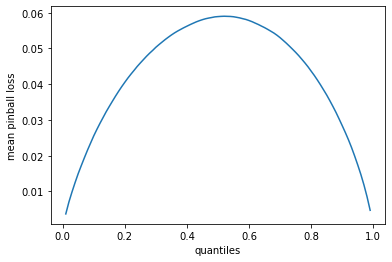

In [213]:
import matplotlib.pyplot as plt

print("Pinball loss of q=0.5 of MSE model", mean_pinball_loss(y_test, all_models["mse"].predict(x_test), alpha=0.5))
print("Pinball loss of q=0.5 of quantile model", mean_pinball_loss(y_test, all_models["q 0.50"].predict(x_test), alpha=0.5))
plt.plot(quantiles, results)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()

In [214]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Quantile sqore: 4.255362489838971


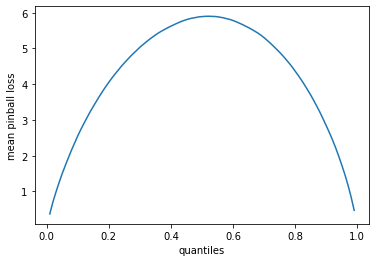

In [215]:
%autoreload
import metrics

plf = metrics.plf_per_quantile(sorted_predictions, y_test)
print("Quantile sqore:", plf.mean())
plt.plot(quantiles, plf)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()

In [216]:
sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[wind_df['new_date'] == dates.unique()[0]].index)]['pos']]

array([[0.02926372, 0.04026565, 0.05273805, ..., 0.        , 0.        ,
        0.        ],
       [0.06802182, 0.0566333 , 0.10611925, ..., 0.01583152, 0.02024023,
        0.01597293],
       [0.11813776, 0.06151804, 0.15465574, ..., 0.05088207, 0.06844088,
        0.06078122],
       ...,
       [0.97329919, 0.94064683, 0.97018611, ..., 0.88640822, 0.9417984 ,
        0.9102519 ],
       [0.97896933, 0.96032084, 0.97098362, ..., 0.89993596, 0.94415401,
        0.93614741],
       [0.98185892, 0.97361542, 0.98372719, ..., 0.92952558, 0.95302706,
        0.95052702]])

In [217]:
y_copy = pd.DataFrame(y_test.copy())
y_copy['pos'] = np.arange(y_test.shape[0])
y_copy

,TARGETVAR,pos
23,0.760455,0
24,0.439244,1
25,0.205808,2
26,0.190020,3
27,0.803496,4
...,...,...
175386,0.342493,11995
175387,0.285135,11996
175388,0.210316,11997
175389,0.135190,11998


In [218]:
y_copy['old_pos'] = y_copy.index
y_copy

,TARGETVAR,pos,old_pos
23,0.760455,0,23
24,0.439244,1,24
25,0.205808,2,25
26,0.190020,3,26
27,0.803496,4,27
...,...,...,...
175386,0.342493,11995,175386
175387,0.285135,11996,175387
175388,0.210316,11997,175388
175389,0.135190,11998,175389


C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


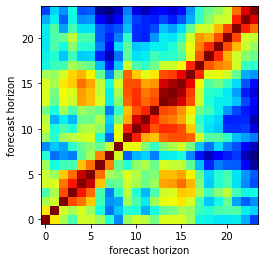

In [219]:
import copula
idx = np.arange(50)
np.random.shuffle(idx)
ZONE = 'ZONE_6'
cov_matrix = np.identity(24)

for i in idx:
    pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == dates.unique()[i]) & (wind_df[ZONE] == 1)].index)]['pos']].T)
    actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == dates.unique()[i]) & (wind_df[ZONE] == 1)].index)]['TARGETVAR']
    cov_matrix = copula.update_cov_matrix(df_y_pred_q=pred, quantiles=quantiles, 
                      actual_data=actual_data, forget_factor=0.9, cov_matrix=cov_matrix)
    
plt.imshow(cov_matrix, cmap='jet', origin='lower')
plt.xlabel('forecast horizon')
plt.ylabel('forecast horizon')

plt.show()

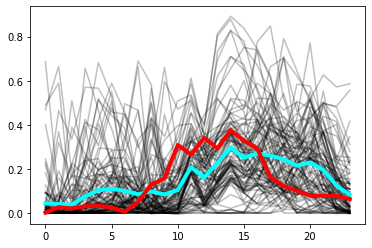

In [220]:
pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == dates.unique()[-1]) & (wind_df[ZONE] == 1)].index)]['pos']].T)
actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == dates.unique()[-1]) & (wind_df[ZONE] == 1)].index)]['TARGETVAR']

generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrix, n_scenarios=100, rnd_seed=[0], sort=True)
plt.plot(generated_scenarios.values, color='k', alpha=0.25)
plt.plot(generated_scenarios.values.mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
plt.plot(np.arange(24), actual_data, color='red', linewidth=4)
plt.show()

In [221]:
import dcor
energy = dcor.energy_distance(generated_scenarios, actual_data)
energy

1.8355037532370286